In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date
today = date.today()
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import string
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import gensim
from itertools import combinations
from util import *

C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Fonctions utlisées dans le code
* Suppression des stopword
* Lemmatisation : Finalement non utlisée car non appropriée à certains mots
* Supression des tags qui ne sont pas dan le TOP 100
* Traitement du C#
* Fonction vide pour TF_IDF afin de ne pas utiliser les tokenizer natifs

In [ ]:
#Lecture du Fichier
df = pd.read_csv('posts_after_prepocessing.csv', sep = ',', encoding='UTF-8')

In [3]:
#Deserialisation de mon Dataframe traité côté Preprocessing
import pickle
with open('df_afterPreprocessing.pickle', 'rb') as file:
    df = pickle.load(file)

In [4]:
#Préprocessing du champ Tittle et Body
df['TitleBody'] = df['TitleBody'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
df['TitleBody'] = df['TitleBody'].map(lambda x: x.replace('\n', ' '))
df['TitleBody'] = df['TitleBody'].map(lambda x: x.replace(':', ''))

punct = string.punctuation
for c in punct:
    if c != '#':
        df['TitleBody'] = df['TitleBody'].map(lambda x: x.replace(c, ''))

#Création des nuages de mots avec NLTK
df['TitleBody_final'] = df.apply(lambda row: nltk.word_tokenize(row['TitleBody'],language='english'), axis=1)

#Supression des StopWord
df['TitleBody_final'] = df.apply(lambda row:removeStopWord(row['TitleBody_final']), axis=1)

#Lemmatisation
#df['TitleBody_final'] = df.apply(lambda row:lemmatisation(row['TitleBody_final']), axis=1)

#Traitement du C#
df['TitleBody_final'] = df.apply(lambda row:processCSharp(row['TitleBody_final']), axis=1)

#Suppressin des numériques
df['TitleBody_final'] = df.apply(lambda row:removeOnlyNumeric(row['TitleBody_final']), axis=1)


In [5]:
df.head(5)

,Id,BODY,Title,Tags,CreationDate,TitleBody,processed_tags_final,processed_body_final,processed_title_final,tags_words,TitleBody_final
0,12051,<p>if i inherit from a base class and want to ...,calling the base constructor in c#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,calling the base constructor in c# if i inheri...,"[c#, .net]","[inherit, base, class, want, pass, something, ...","[calling, base, constructor, c#]","[c#, .net, inheritance, constructor]","[calling, base, constructor, c#, inherit, base..."
1,17319422,<p>i am using pycharm on windows and want to c...,how do i set the maximum line length in pycharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,how do i set the maximum line length in pychar...,[python],"[using, pycharm, windows, want, change, settin...","[set, maximum, line, length, pycharm]","[python, pycharm, pep8]","[set, maximum, line, length, pycharm, using, p..."
2,32664,<p>can anyone tell me if there is a way with g...,is there a constraint that restricts my generi...,<c#><generics><constraints>,2008-08-28 16:04:49,is there a constraint that restricts my generi...,"[c#, generics]","[anyone, tell, way, generics, limit, generic, ...","[constraint, restricts, generic, method, numer...","[c#, generics, constraints]","[constraint, restricts, generic, method, numer..."
3,8763125,<p>i would like to get the keys of a javascrip...,get array of object's keys,<javascript><ecmascript-5>,2012-01-06 19:12:38,get array of objects keys i would like to get ...,[javascript],"[would, like, get, keys, javascript, object, a...","[get, array, objects, keys]","[javascript, ecmascript-5]","[get, array, objects, keys, would, like, get, ..."
5,33923,"<p>whilst starting to learn lisp, i've come ac...",what is tail recursion?,<algorithm><language-agnostic><functional-prog...,2008-08-29 03:48:03,what is tail recursion whilst starting to lear...,"[algorithm, language-agnostic]","[whilst, starting, learn, lisp, ive, come, acr...","[tail, recursion]","[algorithm, language-agnostic, functional-prog...","[tail, recursion, whilst, starting, learn, lis..."


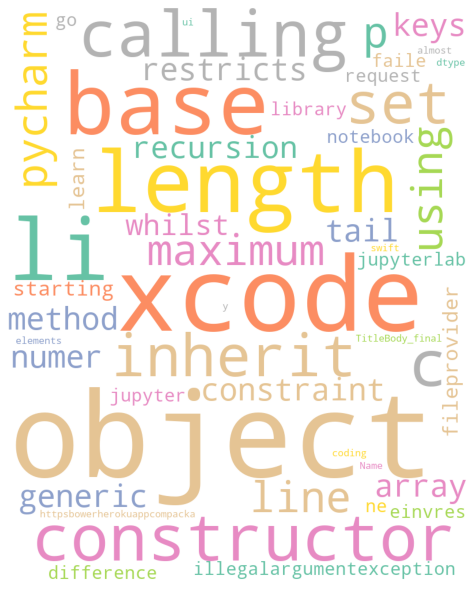

In [6]:
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['TitleBody_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Première étape on vectorize avec TF-IDF

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000,tokenizer=dummy,
        preprocessor=dummy)
tfidf = tfidf_vectorizer.fit_transform(df["TitleBody_final"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

### Selection du nombre de TOPIC
* 'nndsvd': Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)

In [8]:
kmin, kmax = 5, 20
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = NMF( init="nndsvd", n_components=k,max_iter = 300,random_state=42) 
    W = model.fit_transform(tfidf)
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=16 ...
Applying NMF for k=17 ...


C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=18 ...


C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(


Applying NMF for k=19 ...
Applying NMF for k=20 ...


In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [9]:
def calculate_coherence(term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append(nlp(pair[0]).similarity(nlp(pair[1])))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [12]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( tfidf_feature_names, H, topic_index, 10 ) )
    k_values.append( k )
    coherences.append( calculate_coherence(term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

C:\Users\jerom\AppData\Local\Temp/ipykernel_14148/1729474283.py:7: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  pair_scores.append(nlp(pair[0]).similarity(nlp(pair[1])))


K=05: Coherence=0.4404
K=06: Coherence=0.4285
K=07: Coherence=0.4455
K=08: Coherence=0.4486
K=09: Coherence=0.4292
K=10: Coherence=0.4185
K=11: Coherence=0.4328
K=12: Coherence=0.4287
K=13: Coherence=0.4328
K=14: Coherence=0.4321
K=15: Coherence=0.4429
K=16: Coherence=0.4431
K=17: Coherence=0.4370
K=18: Coherence=0.4303
K=19: Coherence=0.4252
K=20: Coherence=0.4384


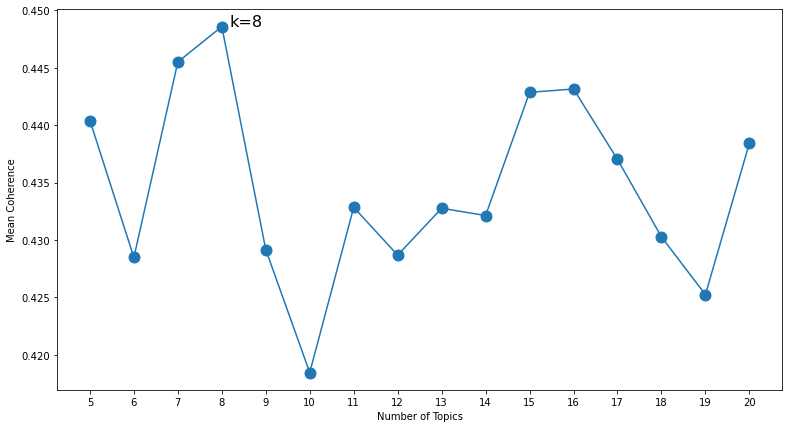

In [13]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

## Puis on calcul les topics avec NMF

In [14]:
#On recupère le nombre de TOPIC optimal, c'est à dire 8
from sklearn.decomposition import NMF
k = 8
# create the model, specifiying the initialization strategy and the number of topics to produce
model = NMF(n_components=k,init="nndsvd",random_state=42,max_iter = 300) 
# apply the model and extract the two factor matrices
W = model.fit_transform(tfidf)
H = model.components_

In [15]:
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( tfidf_feature_names[term_index] )
    return top_terms

In [16]:
descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( tfidf_feature_names, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: class, function, use, code, public, return, method, new, difference, object
Topic 02: git, branch, commit, repository, master, remote, changes, push, commits, pull
Topic 03: string, convert, character, characters, java, strings, split, replace, str, want
Topic 04: div, c#, element, jquery, html, css, height, width, text, input
Topic 05: file, line, files, command, directory, script, run, error, path, bash
Topic 06: array, javascript, object, var, element, elements, convert, numpy, way, value
Topic 07: table, sql, select, mysql, column, database, server, query, data, value
Topic 08: list, python, way, x, lists, dictionary, c#, get, item, like


In [17]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss,jaccard_score
#Fonction qui renvoi différents scores
def print_score(y_test, y_pred):
    print("Hamming loss : {}".format(hamming_loss(y_test, y_pred)))
    print('Subset Accuracy : ', accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
    print('F1-score : ', f1_score(y_test, y_pred, average='micro'))
    print('Jaccard : ', jaccard_score(y_test, y_pred, average='micro'))
    #Revoir les indicateurs avec Jacard

## Nommage TOPIC
* Exemple de code
* GIT
* Traitement des chaines de caractères
* Language Frontend (C#,HTML, CSS)
* Shell
* Gestion des tableaux
* Base de données (SQL, MySQL)
* Python

In [18]:
def plot_top_term_weights( tfidf_feature_names, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( tfidf_feature_names[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

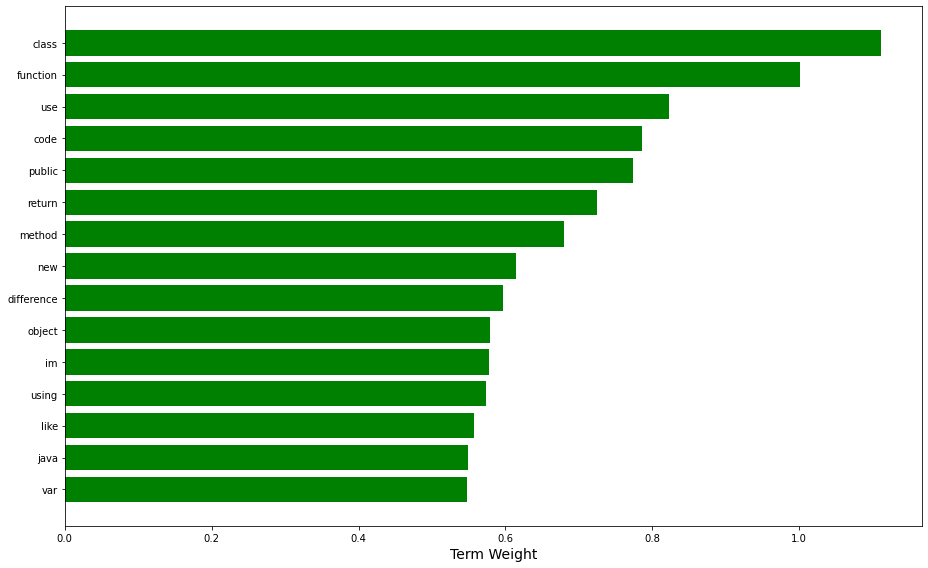

In [19]:
plot_top_term_weights(tfidf_feature_names, H, 0, 15)

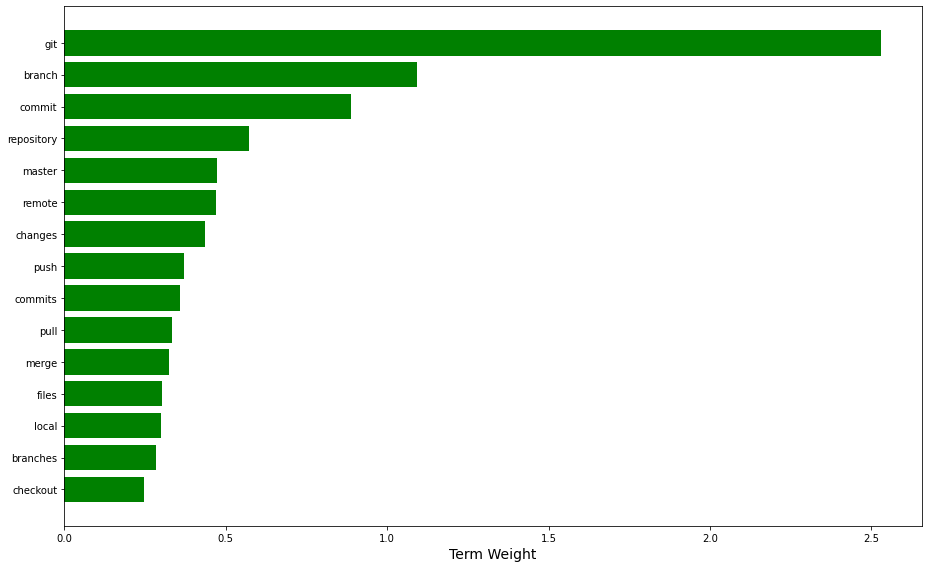

In [20]:
plot_top_term_weights(tfidf_feature_names, H, 1, 15)

# LDA : Latent Dirichlet Allocation après bag of Words
* Détermination des TOPICS
Quels sont les thèmes, les distributions de chaque mot sur les thèmes, la fréquence d’apparition de chaque thème sur le corpus

In [21]:
bow_vectorizer = CountVectorizer(ngram_range = (1,1),
                                 tokenizer=dummy,preprocessor=dummy)
docs_bow = bow_vectorizer.fit_transform(df["TitleBody_final"])

In [22]:
lda = LatentDirichletAllocation(random_state=42,
                                batch_size=400)
params = {'n_components' : [5, 6, 7,8],
          "learning_decay" : [0.7, 0.9],
          "learning_method" : ["batch", "online"]}

#params = {'n_components' : [6,7,8]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5,
                              verbose=2)
gridsearch_lda.fit(docs_bow)

#1 heure d'exécution. Résultat obtenu
#Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 8}
#Best Log Likelihood Score:  -1689928.643148844

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END learning_decay=0.7, learning_method=batch, n_components=5; total time= 1.1min
[CV] END learning_decay=0.7, learning_method=batch, n_components=5; total time= 1.1min
[CV] END learning_decay=0.7, learning_method=batch, n_components=5; total time= 1.1min
[CV] END learning_decay=0.7, learning_method=batch, n_components=5; total time= 1.2min
[CV] END learning_decay=0.7, learning_method=batch, n_components=5; total time= 1.1min
[CV] END learning_decay=0.7, learning_method=batch, n_components=6; total time= 1.2min
[CV] END learning_decay=0.7, learning_method=batch, n_components=6; total time= 1.1min
[CV] END learning_decay=0.7, learning_method=batch, n_components=6; total time= 1.1min
[CV] END learning_decay=0.7, learning_method=batch, n_components=6; total time=  58.8s
[CV] END learning_decay=0.7, learning_method=batch, n_components=6; total time=  59.0s
[CV] END learning_decay=0.7, learning_method=batch, n_components=7; t

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=42),
             param_grid={'learning_decay': [0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [5, 6, 7, 8]},
             verbose=2)

In [23]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 5}
Best Log Likelihood Score:  -1514762.4975996143


In [ ]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
pyLDAvis.display(panel)